Import Dependencies

In [ ]:
import pandas as pd # To create a Pandas dataframe
import matplotlib.pyplot as plt # For visualization
import seaborn as sns # For visualization
import numpy as np # For creating numpy arrays
import kagglehub # To pull datasets from Kaggle
import tensorflow as tf # For creating Nueral Networks
from PIL import Image # For image manipulation and viewing
import os # To create paths, directories, and handle files
from google.colab import files # To Save our files
import zipfile # To handle zip folders
from sklearn.model_selection import train_test_split # For splitting our data
from tensorflow.keras.applications.efficientnet import preprocess_input
import cv2 #For computer Vision
from tqdm import tqdm # To Visualize the completion of loops
from collections import defaultdict # To creatue dictionaries
from tensorflow.keras import layers, models  # Import Keras layers and model APIs for building neural networks
from tensorflow.keras.applications import EfficientNetB0  # Pre-trained EfficientNetB0 model for transfer learning on image data
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Callbacks to stop training early or reduce learning rate on plateau
from sklearn.metrics import classification_report, confusion_matrix , ConfusionMatrixDisplay # Tools to evaluate model performance (precision, recall, confusion matrix)
import pickle  # Used for saving/loading Python objects, like preprocessed datasets or models
#import tensorflow_gan as tfgan  # TensorFlow-GAN: used to build and train GAN models (e.g., cGAN, StyleGAN)
import tensorflow_hub as hub  # TensorFlow Hub: allows loading pre-trained models (e.g., EfficientNet, GAN discriminators)
from glob import glob  # Retrieves file paths matching a pattern (e.g., loading all images from a directory)
import re  # Regular expressions: helpful for extracting labels or information from filenames



Load Metadata and Image files From Kaggle


In [ ]:
# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000


In [ ]:
image_dirs = [
    "/content/HAM10000/HAM10000_images_part_1","/content/HAM10000/HAM10000_images_part_2"
]

In [ ]:
#Load the JSON file to download dataset
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"belusochim","key":"06658aa47d946a159146e2b74b04aa3e"}'}

In [ ]:
# Move kaggle.json to the correct folder
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 600)


In [ ]:
#Download the Dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000


Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
 99% 5.17G/5.20G [00:13<00:00, 575MB/s]
100% 5.20G/5.20G [00:14<00:00, 398MB/s]


In [ ]:
#Extract files from ZipFolder
with zipfile.ZipFile('skin-cancer-mnist-ham10000.zip', 'r') as zip_ref:
    zip_ref.extractall('HAM10000')

In [ ]:
# Load metadata CSV
df = pd.read_csv('HAM10000/HAM10000_metadata.csv')


In [ ]:
print(df.head())          # Preview
print(df.columns)           # See column names
print(df['dx'].value_counts())  # 'dx' is usually the disease label
print(df.isnull().sum())    # See missing values


     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


In [ ]:
#Replace null age with the average age in the dataset
df["age"].fillna(df["age"].mean, inplace=True)

/tmp/ipython-input-10-3940879010.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<bound method Series.mean of 0        80.0
1        80.0
2        80.0
3        80.0
4        75.0
         ... 
10010    40.0
10011    40.0
10012    40.0
10013    80.0
10014    70.0
Name: age, Length: 10015, dtype: float64>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df["age"].fillna(df["age"].mean, inplace=True)


In [ ]:
#Returns the image path if it exists
def find_image_path(image_id):
    for dir_path in image_dirs:
        img_path = os.path.join(dir_path, f"{image_id}.jpg")
        if os.path.exists(img_path):
            return img_path
    return None

In [ ]:
classes = ['bkl', 'bcc', 'akiec', 'vasc', 'nv', 'mel', 'df']
#Mapping Label to Actual Name
class_names = {
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'df': 'Dermatofibroma'
}
num_classes = len(classes)

In [ ]:
#Looking for nullvalues in the dataset
df.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,0
sex,0
localization,0


In [ ]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


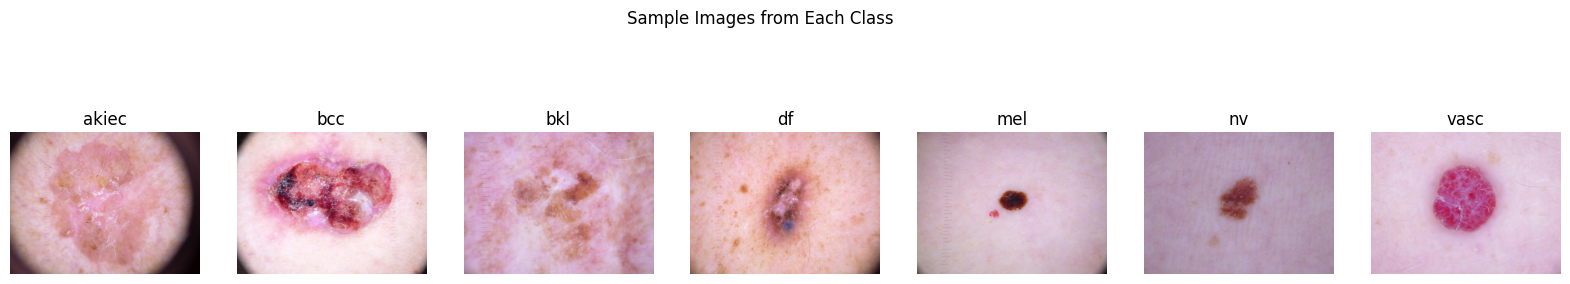

In [ ]:
sample_images = df.groupby('dx').first().reset_index() # Groupds by label
fig, axes = plt.subplots(1, num_classes, figsize=(20, 4)) # Creates subplots(fig=area, axes= image positionings)
for i, row in sample_images.iterrows():
    img_path = find_image_path(row['image_id'])
    if img_path:
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(row['dx'])
        axes[i].axis('off')
    else:
        axes[i].set_title(f"{class_names[row['dx']]} (Not Found)")
        axes[i].axis('off')
plt.suptitle('Sample Images from Each Class')
plt.show()

Exploratory Data Analysis


In [ ]:
#Create a column in our dataset for the imagepath
df['image_path'] = df['image_id'].apply(find_image_path)

Unique classes: ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
Class distribution:
 dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


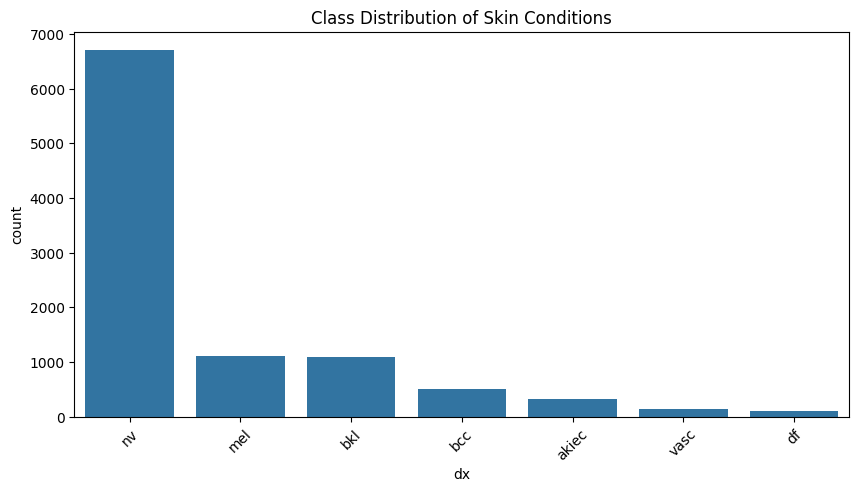

In [ ]:

# Check how many classes we have
print("Unique classes:", df['dx'].unique())
print("Class distribution:\n", df['dx'].value_counts())

# Plot class distribution
plt.figure(figsize=(10,5))
sns.countplot(x='dx', data=df, order=df['dx'].value_counts().index)
plt.title("Class Distribution of Skin Conditions")
plt.xticks(rotation=45)
plt.show()

#There is a big class imabalance in our dataset

Handling Dataset Imbalance Using Sklearn Resample


In [ ]:
#Map label names to integers
label_names = df['dx'].unique()
label_to_index = {name: i for i, name in enumerate(label_names)}

#Add integer labels column to your dataframe
df['label'] = df['dx'].map(label_to_index)
#Divide Dataframe by Label
from sklearn.utils import resample
SIZE = 5000
df_0 = df[df["label"] == 0]
df_1 = df[df["label"] == 1]
df_2 = df[df["label"] == 2]
df_3 = df[df["label"] == 3]
df_4 = df[df["label"] == 4]
df_5 = df[df["label"] == 5]
df_6 = df[df["label"] == 6]

df_0_balanced = resample(df_0, replace=True,n_samples=SIZE,random_state=42)
df_1_balanced = resample(df_1, replace=True,n_samples=SIZE,random_state=42)
df_2_balanced = resample(df_2, replace=True,n_samples=SIZE,random_state=42)
df_3_balanced = resample(df_3, replace=True,n_samples=SIZE,random_state=42)
df_4_balanced = resample(df_4, replace=True,n_samples=SIZE,random_state=42)
df_5_balanced = resample(df_5, replace=True,n_samples=SIZE,random_state=42)
df_6_balanced = resample(df_6, replace=True,n_samples=SIZE,random_state=42)

balanced_dataset = pd.concat([df_0_balanced,df_1_balanced,df_2_balanced,df_3_balanced,df_4_balanced,df_5_balanced,df_6_balanced])

In [ ]:
balanced_dataset.shape

(35000, 9)

<Axes: xlabel='label', ylabel='count'>

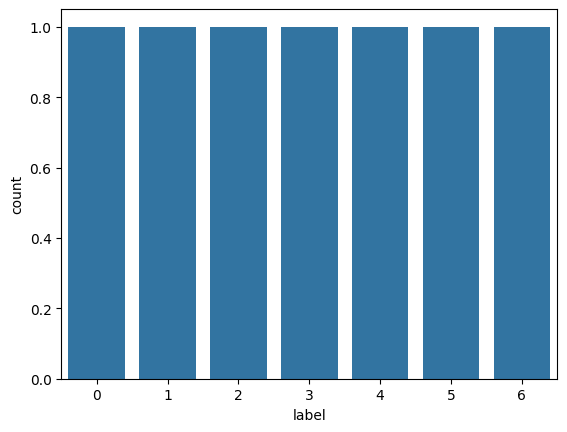

In [ ]:
#Check distribution of balanced Dataset
sns.countplot(balanced_dataset["label"].value_counts())

Split Dataset into Training Testing and Validation In Tensorflow Format


In [ ]:


# Step 2.3: Split the dataframe
train_df, temp_df = train_test_split(balanced_dataset, test_size=0.3, stratify=balanced_dataset['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")

# Step 2.4: Create a function to load image and label from path

def process_path(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3) # For RGB Image
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)  # ✅ Proper preprocessing for EfficientNet
    return image, label

# Step 2.5: Create TensorFlow datasets from the dataframes
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    file_paths = dataframe["image_path"].values
    labels = dataframe['label'].values
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

batch_size = 32
train_ds = df_to_dataset(train_df, shuffle=True, batch_size=batch_size)
val_ds = df_to_dataset(val_df, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test_df, shuffle=False, batch_size=batch_size)


Train size: 24500, Val size: 5250, Test size: 5250


Training Efficient Net Model


In [ ]:

# -----------------------------
# STEP 3: Build EfficientNetB0 Model
# -----------------------------
num_classes = 7

base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# -----------------------------
# STEP 4: Train the Model
# -----------------------------



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
#Train Model on balanced dataset

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=150,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/150
766/766 ━━━━━━━━━━━━━━━━━━━━ 106s 76ms/step - accuracy: 0.4869 - loss: 1.3573 - val_accuracy: 0.7019 - val_loss: 0.8482 - learning_rate: 0.0010
Epoch 2/150
766/766 ━━━━━━━━━━━━━━━━━━━━ 64s 49ms/step - accuracy: 0.6820 - loss: 0.8925 - val_accuracy: 0.7583 - val_loss: 0.7197 - learning_rate: 0.0010
Epoch 3/150
766/766 ━━━━━━━━━━━━━━━━━━━━ 64s 49ms/step - accuracy: 0.7135 - loss: 0.8021 - val_accuracy: 0.7752 - val_loss: 0.6520 - learning_rate: 0.0010
Epoch 4/150
766/766 ━━━━━━━━━━━━━━━━━━━━ 64s 50ms/step - accuracy: 0.7307 - loss: 0.7508 - val_accuracy: 0.7842 - val_loss: 0.6116 - learning_rate: 0.0010
Epoch 5/150
766/766 ━━━━━━━━━━━━━━━━━━━━ 64s 50ms/step - accuracy: 0.7291 - loss: 0.7414 - val_accuracy: 0.8078 - val_loss: 0.5810 - learning_rate: 0.0010
Epoch 6/150
766/766 ━━━━━━━━━━━━━━━━━━━━ 64s 50ms/step - accuracy: 0.7437 - loss: 0.6990 - val_accuracy: 0.8023 - val_loss: 0.5712 - learning_rate: 0.0010
Epoch 7/150
766/766 ━━━━━━━━━━━━━━━━━━━━ 65s 51ms/step - accuracy: 0.

Lets Analyze the Models Classification



In [ ]:
prediction = model.predict(test_ds)


165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step


In [ ]:
prediction = np.argmax(prediction, axis=1)

cr = classification_report(test_df["label"].values, prediction)
print(cr)


              precision    recall  f1-score   support

           0       0.81      0.68      0.74       750
           1       0.82      0.76      0.79       750
           2       0.93      0.99      0.96       750
           3       0.70      0.73      0.72       750
           4       0.98      1.00      0.99       750
           5       0.85      0.91      0.88       750
           6       0.87      0.89      0.88       750

    accuracy                           0.85      5250
   macro avg       0.85      0.85      0.85      5250
weighted avg       0.85      0.85      0.85      5250



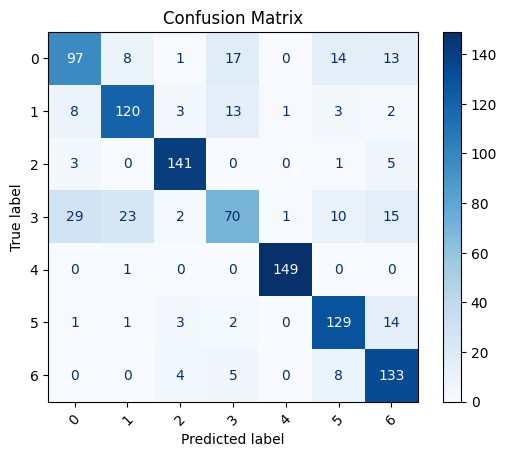

In [ ]:
true_labels = np.array(test_df["label"].values)

# --- Predicted labels ---
# Replace this with your actual prediction
# Ensure it's a 1D array of class indices (like [0, 2, 1, ...])
predicted_labels = np.asarray(prediction)
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Save model
filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))



In [ ]:
# To load the model later:
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
# The base model got an accuracy of 82%

In [ ]:
# Example: manually flagging known dark skin samples
balanced_dataset['skin_type'] = 'light'  # default
balanced_dataset.loc[balanced_dataset['image_path'].isin(['img001.jpg', 'img003.jpg', 'img045.jpg']), 'skin_type'] = 'dark'

# Filter the DataFrame
dark_skin_df = balanced_dataset[balanced_dataset['skin_type'] == 'dark']


Lets Train a GAN To Generate Dark Skin Images To Improve Accuracy


In [ ]:
# For this tax we will rely on the brightness level of the image with low brigthness signifying dark image

brightness_values = []

def compute_brightness(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.resize(img, (64, 64))  # Resize for faster processing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)

# Loop through all image paths
for path in tqdm(balanced_dataset['image_path'].values):
    brightness = compute_brightness(path)
    brightness_values.append(brightness)

# Add brightness column to your dataframe
balanced_dataset['brightness'] = brightness_values


100%|██████████| 7000/7000 [00:38<00:00, 183.42it/s]


In [ ]:
balanced_dataset[balanced_dataset["brightness"] <110]

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,label,skin_type,brightness
792,HAM_0003574,ISIC_0030835,bkl,confocal,50.0,male,face,/content/HAM10000/HAM10000_images_part_2/ISIC_...,0,light,94.749756
187,HAM_0004975,ISIC_0032863,bkl,histo,85.0,male,chest,/content/HAM10000/HAM10000_images_part_2/ISIC_...,0,light,107.235596
191,HAM_0007384,ISIC_0033410,bkl,histo,65.0,female,face,/content/HAM10000/HAM10000_images_part_2/ISIC_...,0,light,109.203613
792,HAM_0003574,ISIC_0030835,bkl,confocal,50.0,male,face,/content/HAM10000/HAM10000_images_part_2/ISIC_...,0,light,94.749756
250,HAM_0004555,ISIC_0034259,bkl,histo,75.0,male,lower extremity,/content/HAM10000/HAM10000_images_part_2/ISIC_...,0,light,101.729004
237,HAM_0002372,ISIC_0034031,bkl,histo,65.0,male,neck,/content/HAM10000/HAM10000_images_part_2/ISIC_...,0,light,96.682861
5665,HAM_0002152,ISIC_0030234,nv,follow_up,45.0,male,trunk,/content/HAM10000/HAM10000_images_part_2/ISIC_...,1,light,108.813965
3275,HAM_0006228,ISIC_0028594,nv,follow_up,35.0,female,genital,/content/HAM10000/HAM10000_images_part_1/ISIC_...,1,light,88.947998
3485,HAM_0006649,ISIC_0031995,nv,follow_up,35.0,male,lower extremity,/content/HAM10000/HAM10000_images_part_2/ISIC_...,1,light,107.017822
5898,HAM_0001225,ISIC_0025977,nv,follow_up,25.0,female,trunk,/content/HAM10000/HAM10000_images_part_1/ISIC_...,1,light,105.451416


In [ ]:
# Pick a threshold based on inspection
threshold = 110
balanced_dataset['skin_type'] = balanced_dataset['brightness'].apply(lambda b: 'dark' if b is not None and b < threshold else 'other')
dark_skin_df = balanced_dataset[balanced_dataset["skin_type"] == 'dark']
print(f"Found {len(dark_skin_df)} dark skin images.")


Found 40 dark skin images.


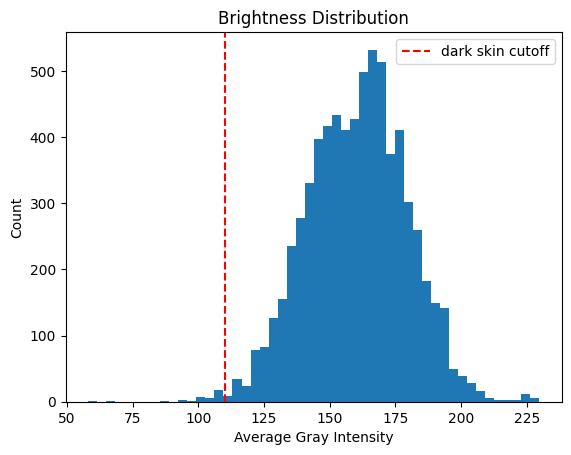

In [ ]:
plt.hist(balanced_dataset['brightness'].dropna(), bins=50)
plt.axvline(threshold, color='red', linestyle='--', label='dark skin cutoff')
plt.title('Brightness Distribution')
plt.xlabel('Average Gray Intensity')
plt.ylabel('Count')
plt.legend()
plt.show()


In [ ]:
dark_skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,label,skin_type,brightness
792,HAM_0003574,ISIC_0030835,bkl,confocal,50.0,male,face,/content/HAM10000/HAM10000_images_part_2/ISIC_...,0,dark,94.749756
187,HAM_0004975,ISIC_0032863,bkl,histo,85.0,male,chest,/content/HAM10000/HAM10000_images_part_2/ISIC_...,0,dark,107.235596
191,HAM_0007384,ISIC_0033410,bkl,histo,65.0,female,face,/content/HAM10000/HAM10000_images_part_2/ISIC_...,0,dark,109.203613
792,HAM_0003574,ISIC_0030835,bkl,confocal,50.0,male,face,/content/HAM10000/HAM10000_images_part_2/ISIC_...,0,dark,94.749756
250,HAM_0004555,ISIC_0034259,bkl,histo,75.0,male,lower extremity,/content/HAM10000/HAM10000_images_part_2/ISIC_...,0,dark,101.729004
237,HAM_0002372,ISIC_0034031,bkl,histo,65.0,male,neck,/content/HAM10000/HAM10000_images_part_2/ISIC_...,0,dark,96.682861
5665,HAM_0002152,ISIC_0030234,nv,follow_up,45.0,male,trunk,/content/HAM10000/HAM10000_images_part_2/ISIC_...,1,dark,108.813965
3275,HAM_0006228,ISIC_0028594,nv,follow_up,35.0,female,genital,/content/HAM10000/HAM10000_images_part_1/ISIC_...,1,dark,88.947998
3485,HAM_0006649,ISIC_0031995,nv,follow_up,35.0,male,lower extremity,/content/HAM10000/HAM10000_images_part_2/ISIC_...,1,dark,107.017822
5898,HAM_0001225,ISIC_0025977,nv,follow_up,25.0,female,trunk,/content/HAM10000/HAM10000_images_part_1/ISIC_...,1,dark,105.451416


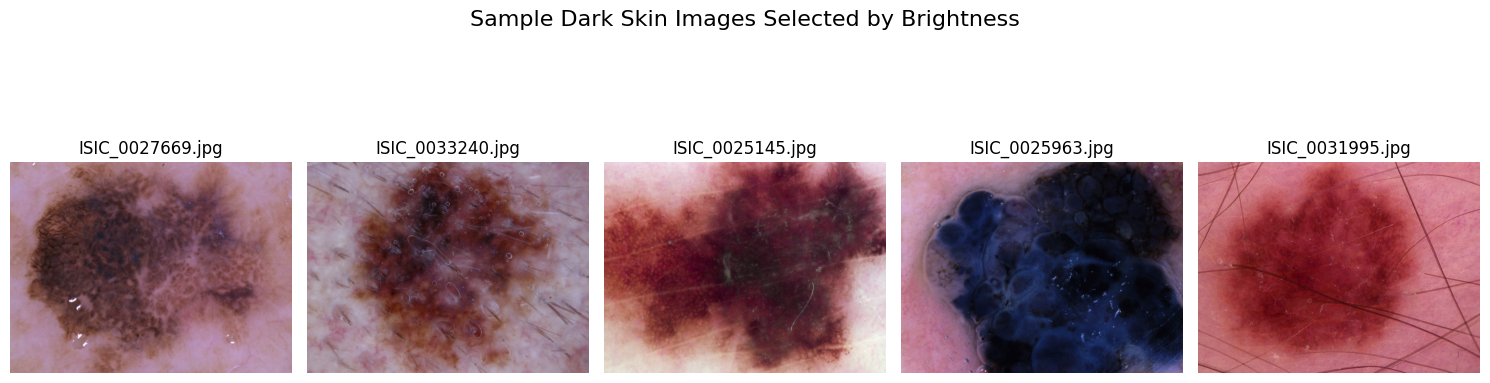

In [ ]:
sample_paths = dark_skin_df['image_path'].sample(5).values

# Plot them
plt.figure(figsize=(15, 5))
for i, path in enumerate(sample_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"{path.split('/')[-1]}")
    plt.axis('off')
plt.suptitle("Sample Dark Skin Images Selected by Brightness", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
IMG_SIZE = 64  # Small size for DCGAN
dark_skin_images = []

for path in tqdm(dark_skin_df['image_path'].values):
    img = cv2.imread(path)
    if img is None:
        continue
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = (img / 127.5) - 1  # Normalize to [-1, 1]
    dark_skin_images.append(img)


# Convert to numpy array
X_dark = np.array(dark_skin_images, dtype=np.float32)
print(f"Loaded {X_dark.shape[0]} dark skin images with shape {X_dark.shape[1:]}")


100%|██████████| 40/40 [00:00<00:00, 181.32it/s]

Loaded 40 dark skin images with shape (64, 64, 3)




1.   List item
2.   List item



In [ ]:
X_dark.shape


(40, 64, 64, 3)

Lets Oversample minority Classes


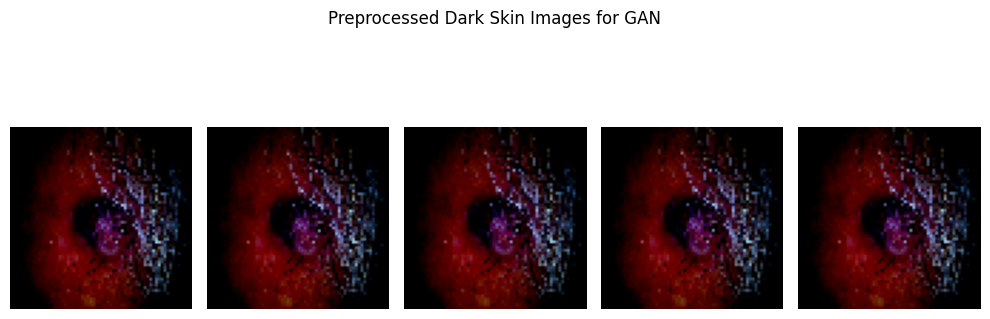

In [ ]:
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Preprocessed Dark Skin Images for GAN")
plt.tight_layout()
plt.show()


Building the GAN To Generate more Dark Skin Images


In [ ]:


def make_generator_model():
    model = models.Sequential(name="Generator")

    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))  # Shape: (8, 8, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())           # Shape: (16, 16, 128)

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())           # Shape: (32, 32, 64)

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # Output shape: (64, 64, 3)

    return model

generator = make_generator_model()
generator.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 16384)          │     1,638,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 3)      │         4,800 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,733,504 (10.43 MB)

 Trainable params: 2,700,352 (10.30 MB)

 Non-trainable params: 33,152 (129.50 KB)

In [ ]:
def make_discriminator_model():
    model = models.Sequential(name="Discriminator")

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # No activation for logits

    return model

discriminator = make_discriminator_model()
discriminator.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,561 (947.50 KB)

 Trainable params: 242,561 (947.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:


# ----------------------------
# Hyperparameters
# ----------------------------
EPOCHS = 400
BATCH_SIZE = 32
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16
SAVE_INTERVAL = 20
SAVE_DIR = 'gan_outputs'
MODEL_SAVE_DIR = 'saved_gan_generator'

# Seed for consistent image generation
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

# ----------------------------
# Losses and Optimizers
# ----------------------------
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # want to fool the discriminator

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# ----------------------------
# Training Step Function
# ----------------------------
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# ----------------------------
# Image Generation & Save
# ----------------------------
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1.0) / 2.0  # Scale [-1, 1] to [0, 1]

    os.makedirs(SAVE_DIR, exist_ok=True)
    plt.figure(figsize=(8, 8))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i])
        plt.axis('off')

    plt.suptitle(f"Generated Images - Epoch {epoch + 1}")
    file_path = os.path.join(SAVE_DIR, f"epoch_{epoch + 1}.png")
    plt.tight_layout()
    plt.savefig(file_path)
    plt.show()

# ----------------------------
# Main Training Loop
# ----------------------------
def train(dataset, epochs):
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        g_loss, d_loss = 0, 0
        num_batches = 0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            g_loss += gen_loss
            d_loss += disc_loss
            num_batches += 1

        print(f"  Generator loss: {g_loss / num_batches:.4f} | Discriminator loss: {d_loss / num_batches:.4f}")

        if (epoch + 1) % SAVE_INTERVAL == 0:
            generate_and_save_images(generator, epoch, seed)
            generator.save(os.path.join(MODEL_SAVE_DIR, f"generator_epoch_{epoch + 1}.h5"))
            print(f"✅ Generator saved at epoch {epoch + 1}")

# ----------------------------
# Call train() to start training
# ----------------------------
train_dataset = tf.data.Dataset.from_tensor_slices(X_dark).shuffle(1000).batch(BATCH_SIZE)
train(train_dataset, EPOCHS)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("X_dark shape:", X_dark.shape)       # Should be (N, 64, 64, 3)
print("dtype:", X_dark.dtype)              # Should be float32
print("min/max pixel values:", np.min(X_dark), np.max(X_dark))  # Should be in [-1, 1]



X_dark shape: (40, 64, 64, 3)
dtype: float32
min/max pixel values: -1.0 1.0


In [ ]:
pip install tensorflow-gan


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 6.2 MB/s eta 0:00:00


OSError: [Errno 39] Directory not empty: 'synthetic_images'

In [ ]:


TARGET_COUNT = 4000
SAVE_DIR = "Syntetic_Images"
os.makedirs(SAVE_DIR, exist_ok=True)

# Count existing images per class
class_counts = train_df['label'].value_counts().sort_index()
print("Original class counts:\n", class_counts)

# Calculate how many to generate per class
samples_needed = {cls: TARGET_COUNT - count for cls, count in class_counts.items() if count < TARGET_COUNT}
print("Samples to generate per class:", samples_needed)

# Generate and save synthetic images
def generate_images(generator, n_images, noise_dim=100):
    noise = tf.random.normal([n_images, noise_dim])
    images = generator(noise, training=False)
    images = (images + 1) / 2.0  # scale to [0,1]
    return images.numpy()

# Loop and save
for cls, num_to_generate in samples_needed.items():
    print(f"Generating {num_to_generate} images for class {cls}...")
    imgs = generate_images(generator, num_to_generate)

    for i, img in enumerate(imgs):
        img = (img * 255).astype(np.uint8)
        img = Image.fromarray(img)
        img_path = os.path.join(SAVE_DIR, f"class_{cls}_img_{i}.jpg")
        img.save(img_path)


Original class counts:
 label
0    3500
1    3500
2    3500
3    3500
4    3500
5    3500
6    3500
Name: count, dtype: int64
Samples to generate per class: {0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500}
Generating 500 images for class 0...
Generating 500 images for class 1...
Generating 500 images for class 2...
Generating 500 images for class 3...
Generating 500 images for class 4...
Generating 500 images for class 5...
Generating 500 images for class 6...


In [ ]:

# Path to your synthetic images folder
SYNTHETIC_DIR = "/content/Syntetic_Images"

# Get list of all image file paths
synthetic_paths = glob(os.path.join(SYNTHETIC_DIR, "*.jpg"))

# Extract class labels safely using regex
synthetic_labels = []
for path in synthetic_paths:
    filename = os.path.basename(path)  # e.g., class_4_img_0.jpg
    match = re.search(r'class_(\d+)_img', filename)
    if match:
        synthetic_labels.append(int(match.group(1)))
    else:
        raise ValueError(f"Filename {filename} does not match expected pattern.")

# Create synthetic DataFrame
synthetic_df = pd.DataFrame({
    "image_path": synthetic_paths,
    "label": synthetic_labels
})

# Concatenate with original training DataFrame
train_df_augmented = pd.concat([train_df, synthetic_df], ignore_index=True)

print(f"Original train size: {len(train_df)}")
print(f"Synthetic images added: {len(synthetic_df)}")
print(f"New training set size: {len(train_df_augmented)}")


Original train size: 24500
Synthetic images added: 3500
New training set size: 28000


In [ ]:
train_ds = df_to_dataset(train_df_augmented, shuffle=True, batch_size=32)


NameError: name 'df_to_dataset' is not defined

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
)


NameError: name 'model' is not defined

In [ ]:
predicted = model.predict(test_ds)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


In [ ]:
prediction = np.argmax(predicted, axis=1)

cr = classification_report(test_df["label"].values, prediction)
print(cr)


              precision    recall  f1-score   support

           0       0.76      0.62      0.68       150
           1       0.74      0.80      0.77       150
           2       0.90      0.97      0.93       150
           3       0.65      0.49      0.56       150
           4       0.99      0.98      0.98       150
           5       0.78      0.90      0.83       150
           6       0.79      0.87      0.83       150

    accuracy                           0.80      1050
   macro avg       0.80      0.80      0.80      1050
weighted avg       0.80      0.80      0.80      1050



In [ ]:
# Save model
filename = 'HealthModel.h5'
pickle.dump(model, open(filename, 'wb'))



NameError: name 'pickle' is not defined

In [ ]:
#Load Model
HealthCareModel = pickle.load(open(filename, 'rb'))

In [ ]:
img_path = find_image_path(df["image_path"][0])

In [ ]:
img_path = df["image_path"][78]

In [ ]:
print(img_path)

/content/HAM10000/HAM10000_images_part_2/ISIC_0032283.jpg


In [ ]:
feed_img, correct_label = process_path(img_path, df["label"][0])
img = tf.expand_dims(feed_img, axis=0)  # Shape becomes (1, 224, 224, 3)
print(feed_img.shape, img.shape)

(224, 224, 3) (1, 224, 224, 3)


In [ ]:
prediction  =HealthCareModel.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [ ]:
predicted_index = np.argmax(prediction)
confidence = np.max(prediction)

# Map index to class name
predicted_class = class_names[classes[predicted_index]]

print("🧾 Diagnosis:", predicted_class)
print(f"✅ Confidence: {confidence * 100:.2f}%")

🧾 Diagnosis: Benign keratosis-like lesions
✅ Confidence: 71.27%
